In [1]:
# A Template NEMS Script suitable for beginners
# Please see docs/architecture.svg for a visual diagram of this code

import logging
import pickle
from pathlib import Path
import gzip
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import nems0.analysis.api
import nems0.initializers
import nems0.preprocessing as preproc
import nems0.uri
from nems0 import db
from nems0 import xforms
from nems0 import recording
from nems0.fitters.api import scipy_minimize
from nems0.signal import RasterizedSignal
from nems import Model

log = logging.getLogger(__name__)

# CONFIGURATION

# figure out data and results paths:
signals_dir = Path(nems0.NEMS_PATH) / 'recordings'
modelspecs_dir = Path(nems0.NEMS_PATH) / 'modelspecs'

In [2]:
def plot_binaural_model(model, X_val, Y_val=None):
    
    # Predict the response to the stimulus spectrogram using the fitted model.
    prediction = model.predict(X_val)
    if Y_val is None:
        cc=0
        nmse=1
    else:
        cc = np.corrcoef(prediction[:, 0], Y_val[:, 0])[0, 1]
        nmse = np.std(prediction-Y_val) / np.std(Y_val)

    wc = model.layers[0].coefficients
    fir = model.layers[1].coefficients

    if len(wc.shape)>2:
        strf=wc[:,:,0] @ fir[:,:,0].T
        if wc.shape[2]>1:
            strf2=wc[:,:,1] @ fir[:,:,1].T
        else:
            strf2=strf.copy()
    elif len(fir.shape)>2:
        strf=wc @ fir[:,:,0].T
        if fir.shape[2]>1:
            strf2=wc @ fir[:,:,1].T
        else:
            strf2 = strf.copy()
    else:
        strf=wc @ fir.T
        strf2 = strf.copy()
    strf *= model.layers[2].coefficients[0]
    strf2 *= model.layers[2].coefficients[1]
    cmax=np.max([np.abs(strf).max(), np.abs(strf2).max()])

    fig=plt.figure()
    spec = fig.add_gridspec(3, 4)

    ax0 = fig.add_subplot(spec[0, :])
    ax1 = fig.add_subplot(spec[1, :])
    ax20 = fig.add_subplot(spec[2, 0])
    ax21 = fig.add_subplot(spec[2, 1])
    ax22 = fig.add_subplot(spec[2, 2:])
    
    bins=550
    b0=0
    b1=b0+bins
    fs=100
    dur=bins/fs
    chans = X_val.shape[1]
    t=np.linspace(0,dur,bins)
    _x = np.reshape(np.transpose(X_val[b0:b1,:,:],[0,2,1]),(bins,-1)).T
    ax0.imshow(_x, aspect='auto', extent=[0,dur,-0.5,chans+0.5])
    ax0.set_title(f"{model.name} cc={cc:.3f} nmse={nmse:.3f}")
    if Y_val is not None:
        ax1.plot(t,Y_val[b0:b1,0])
    ax1.plot(t,prediction[b0:b1,0])
    ax1.set_xlim(ax0.get_xlim())
    ax20.imshow(strf, origin='lower', extent=[0,strf.shape[1],-0.5,chans+0.5], clim=[-cmax, cmax])
    ax21.imshow(strf2, origin='lower', extent=[0,strf.shape[1],-0.5,chans+0.5], clim=[-cmax, cmax])

    xin = model.evaluate(input=X_val, n=len(model.layers)-2)['_last_output']
    xrange = np.linspace(xin.min(),xin.max(),100)[:,np.newaxis]
    xout = model.layers[-1].evaluate(xrange)
    if Y_val is not None:
        ax22.plot(xin[:,0],Y_val[:,0],'.', markersize=2, color='lightgray')
    ax22.plot(xrange[:,0],xout[:,0], color='k')


In [3]:
def plot_binaural_layers(model, X_val, Y_val=None):
    x1 = model.evaluate(input=X_val, n=0)['_last_output']
    x2 = model.evaluate(input=X_val, n=1)['_last_output']
    x3 = model.evaluate(input=X_val, n=2)['_last_output']
    x4 = model.evaluate(input=X_val, n=3)['output']

    f,ax = plt.subplots(6,1, sharex=True)

    ax[0].imshow(X_val[:1000,:,0].T, aspect='auto', interpolation='none')
    ax[0].set_ylabel('stim 0')

    ax[1].imshow(X_val[:1000,:,1].T, aspect='auto', interpolation='none')
    ax[1].set_ylabel('stim 1')

    ax[2].plot(x1[:1000,:,0])
    ax[2].plot(x1[:1000,:,1], '--')
    ax[2].set_ylabel('wc1 output')

    ax[3].plot(x2[:1000,0])
    ax[3].plot(x2[:1000,1], '--')
    ax[3].set_ylabel('fir output')

    ax[4].plot(x3[:1000,:])
    ax[4].set_ylabel('wc1 output')

    ax[5].plot(x4[:1000,:])
    if Y_val is not None:
        ax[5].plot(Y_val[:1000,0])
    ax[5].set_ylabel('dexp output')

In [4]:
def simulate_binaural(X, modelspec='wc.18x2x2.b-fir.15x2x2-wc.2x1-relu.1.o.s', verbose=False):
    
    models = Model.from_keywords(modelspec)
    wc=models.layers[0].coefficients
    wc[:] = 0
    #wc[4,1,0] = 0.5
    #wc[5,1,0] = -0.5
    wc[7,0,1] = 1
    wc[8,0,1] = 0.5
    models.layers[0]['coefficients'] = wc

    fir=models.layers[1].coefficients
    fir[:] = 0
    fir[1,1,0] = 1
    fir[2,1,0] = 1
    fir[1,0,1] = 1
    fir[2,0,1] = 0.5
    models.layers[1]['coefficients'] = fir

    wc2=models.layers[2].coefficients
    wc2[:]= 0
    wc2[0] = 1
    wc2[1] = 1
    models.layers[2]['coefficients']=wc2
    
    Y = models.predict(X)
    Y = Y + np.random.randn(len(Y),1)/Y.std()*0.05
    if verbose:
        plot_binaural_model(models, X, Y_val=Y)
    
    return Y

In [5]:
batch=338
modelname="gtgram.fs100.ch18.mono-ld.pop-norm.l1-sev_wc.Nx60-fir.1x20x60-wc.60xR-lvl.R-dexp.R_tfinit.n.lr1e3.et3.es20-newtf.n.lr1e4"
# raw binaural model
#recording_uri = '/auto/data/nems_db/recordings/338/CLT041c_c6cec16ea49389fffff3880d5742bfc3a3cf4924.tgz'
recording_uri = '/auto/data/nems_db/recordings/338/CLT039c_dd50ace1b2f07b2fa485d44fa09f5908ca222e0d.tgz'
rec = recording.load_recording(recording_uri)

# "HRTF" binaural model
recording_uri = '/auto/data/nems_db/recordings/338/CLT039c_03fad55eb0b91a734d800a85ad3a78ae790c7d36.tgz'
rec_hrtf = recording.load_recording(recording_uri)

rec['stim_hrtf'] = rec_hrtf['stim']

ctx = {'rec': rec}
ctx.update(xforms.normalize_sig(sig='resp', norm_method='minmax', **ctx))
ctx.update(xforms.normalize_sig(sig='stim', norm_method='minmax', log_compress=1, **ctx))
ctx.update(xforms.normalize_sig(sig='stim_hrtf', norm_method='minmax', log_compress=1, **ctx))
ctx.update(xforms.split_by_occurrence_counts(epoch_regex='^STIM', **ctx))
ctx.update(xforms.average_away_stim_occurrences(epoch_regex='^STIM', **ctx))

[nems0.xforms INFO] xforms.normalize_sig(minmax): resp b=0.0, g=3.8181818181818183, dlog(..., -None)
[nems0.xforms INFO] xforms.normalize_sig(minmax): stim b=0.0, g=5.311554912564187, dlog(..., -1)
[nems0.xforms INFO] xforms.normalize_sig(minmax): stim_hrtf b=0.0, g=5.1749485177800185, dlog(..., -1)


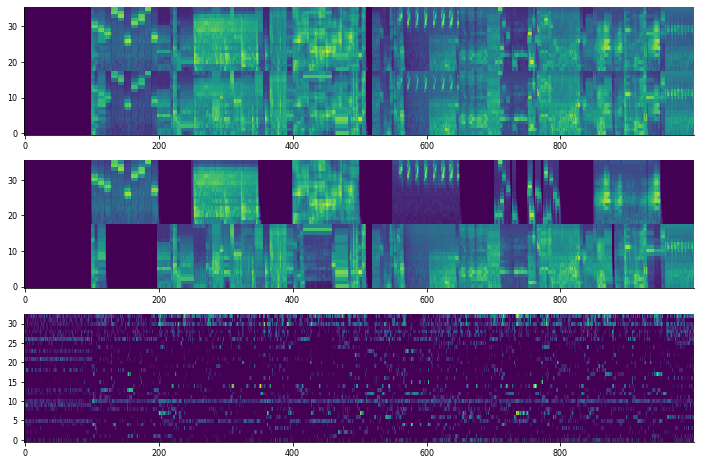

In [6]:
X_all_h = ctx['val']['stim_hrtf'].as_continuous()
X_all = ctx['val']['stim'].as_continuous()
Y_all = ctx['val']['resp'].as_continuous()
f,ax = plt.subplots(3,1, figsize=(12,8))
ax[0].imshow(X_all_h[:,:1000], aspect='auto', interpolation='none', origin='lower')
ax[1].imshow(X_all[:,:1000], aspect='auto', interpolation='none', origin='lower')
ax[2].imshow(Y_all[:,:1000], aspect='auto', interpolation='none', origin='lower')

In [7]:
# testing binaural NAT with various model architectures.
cellids = [rec['resp'].chans[6]]
cellids = [rec['resp'].chans[19]]
cellids = [rec['resp'].chans[30]]
cellids = [rec['resp'].chans[10]]
cellids = [rec['resp'].chans[4]]

print("cellids: ", cellids)

X_est_h = ctx['est']['stim_hrtf'].as_continuous().T.copy()
X_est = ctx['est']['stim'].as_continuous().T.copy()
Y_est = ctx['est']['resp'].extract_channels(cellids).as_continuous().T
X_val_h = ctx['val']['stim_hrtf'].as_continuous().T.copy()
X_val = ctx['val']['stim'].as_continuous().T.copy()
Y_val = ctx['val']['resp'].extract_channels(cellids).as_continuous().T

X_norm = X_est.max()
X_est_h /= X_norm
X_est /= X_norm
X_val_h /= X_norm
X_val /= X_norm

if True:
    # binaural STRF
    X_est_h=np.swapaxes(np.reshape(X_est_h, [-1, 2, 18]), 2, 1)
    X_est=np.swapaxes(np.reshape(X_est, [-1, 2, 18]), 2, 1)
    X_val_h=np.swapaxes(np.reshape(X_val_h, [-1, 2, 18]), 2, 1)
    X_val=np.swapaxes(np.reshape(X_val, [-1, 2, 18]), 2, 1)

    # shorten est data for speed
    #X_est_h = X_est_h[:150000, :, :]
    #X_est = X_est[:150000, :, :]
    #Y_est = Y_est[:150000, :]

    modelspec = 'wc.18x3x1.b-fir.15x3x1-wc.2x1-dexp.1'
    modelspec = 'wc.18x2x2.b-fir.15x2x2-wc.2x1-relu.1.o.s'
    modelspec = 'wc.18x2x2.b-fir.15x2x2-wc.2x1-dexp.1'
else:
    modelspec = 'wc.36x2-fir.15x2-dexp.1'

    # shorten est data for speed
    X_est_h = X_est_h[:50000, :]
    X_est = X_est[:50000, :]
    Y_est = Y_est[:50000, :]

cellids:  ['CLT039c-016-1']


In [8]:
X_est_h.shape

(396000, 18, 2)

## Simulate specific tuning

In [9]:
simulate=False
if simulate:
    print('simulating response vectors')
    Y_est = simulate_binaural(X_est_h, modelspec='wc.18x2x2.b-fir.15x2x2-wc.2x1-relu.1.o.s', verbose=False)
    Y_val = simulate_binaural(X_val_h, modelspec='wc.18x2x2.b-fir.15x2x2-wc.2x1-relu.1.o.s', verbose=True)

## Initialize model, plot initialized model

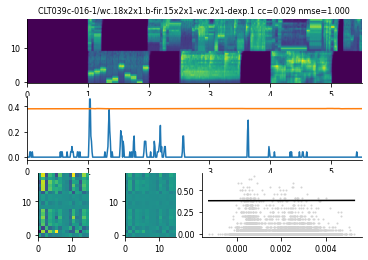

In [10]:
modelspec = 'wc.18x2x1.b-fir.15x2x1-wc.2x1-dexp.1'
model0 = Model.from_keywords(modelspec)
model0.name = f"{cellids[0]}/{modelspec}"

# Set initial values
# quick & dirty, but may not work as desired
model0 = model0.sample_from_priors()
model0 = model0.sample_from_priors()
#model0 = model0.sample_from_priors()

plot_binaural_model(model0, X_val, Y_val=Y_val)

## Fit with TF backend

In [11]:
fitter_options = {'cost_function': 'nmse', 'early_stopping_delay': 100, 
                  'early_stopping_patience': 10,
                  'early_stopping_tolerance': 1e-3, 'validation_split': 0.0,
                  'learning_rate': 5e-3, 'epochs': 2000}

# Trying a TF fit:
model = model0.copy()
model.layers[-1].skip_nonlinearity()
model = model.fit(input=np.expand_dims(X_est_h, axis=0),
          target=np.expand_dims(Y_est, axis=0), backend='tf',
          fitter_options=fitter_options,
          batch_size=None)

fitter_options['early_stopping_tolerance'] = 1e-4
fitter_options['learning_rate'] = 1e-3
model.layers[-1].unskip_nonlinearity()
model = model.fit(input=np.expand_dims(X_est_h, axis=0),
          target=np.expand_dims(Y_est, axis=0), backend='tf',
          fitter_options=fitter_options,
          batch_size=None)

2022-09-07 13:42:58.188708: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-07 13:42:58.834943: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 7287 MB memory:  -> device: 0, name: GeForce GTX 1080, pci bus id: 0000:65:00.0, compute capability: 6.1


1 Physical GPUs, 1 Logical GPUs
TF model built...
Model: "CLT039c-016-1/wc.18x2x1.b-fir.15x2x1-wc.2x1-dexp.1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 396000, 18, 2)]   0         
                                                                 
 wc (WeightChannelsMultiTF)  (None, 396000, 2, 2)      36        
                                                                 
 fir (FiniteImpulseResponseT  (None, 396000, 2)        30        
 F)                                                              
                                                                 
 wc0 (WeightChannelsTF)      (None, 396000, 1)         2         
                                                                 
 dexp (StaticNonlinearityTF)  (None, 396000, 1)        4         
                                                                 
Total params: 72
Trainable param

2022-09-07 13:42:59.967121: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 7605
2022-09-07 13:42:59.971518: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-09-07 13:42:59.974096: W tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 10.2.89, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


Epoch 1/2000
1/1 [==============================] - 1s 571ms/step - loss: 3.3338
Epoch 2/2000
1/1 [==============================] - 0s 54ms/step - loss: 3.2242
Epoch 3/2000
1/1 [==============================] - 0s 58ms/step - loss: 3.1296
Epoch 4/2000
1/1 [==============================] - 0s 53ms/step - loss: 3.0413
Epoch 5/2000
1/1 [==============================] - 0s 53ms/step - loss: 2.9529
Epoch 6/2000
1/1 [==============================] - 0s 54ms/step - loss: 2.8600
Epoch 7/2000
1/1 [==============================] - 0s 53ms/step - loss: 2.7587
Epoch 8/2000
1/1 [==============================] - 0s 48ms/step - loss: 2.6458
Epoch 9/2000
1/1 [==============================] - 0s 51ms/step - loss: 2.5184
Epoch 10/2000
1/1 [==============================] - 0s 52ms/step - loss: 2.3738
Epoch 11/2000
1/1 [==============================] - 0s 52ms/step - loss: 2.2104
Epoch 12/2000
1/1 [==============================] - 0s 51ms/step - loss: 2.0281
Epoch 13/2000
1/1 [=================

1/1 [==============================] - 0s 51ms/step - loss: 3.6288
Epoch 75/2000
1/1 [==============================] - 0s 47ms/step - loss: 3.6018
Epoch 76/2000
1/1 [==============================] - 0s 52ms/step - loss: 3.5760
Epoch 77/2000
1/1 [==============================] - 0s 51ms/step - loss: 3.5513
Epoch 78/2000
1/1 [==============================] - 0s 52ms/step - loss: 3.5275
Epoch 79/2000
1/1 [==============================] - 0s 51ms/step - loss: 3.5045
Epoch 80/2000
1/1 [==============================] - 0s 51ms/step - loss: 3.4823
Epoch 81/2000
1/1 [==============================] - 0s 48ms/step - loss: 3.4607
Epoch 82/2000
1/1 [==============================] - 0s 49ms/step - loss: 3.4397
Epoch 83/2000
1/1 [==============================] - 0s 52ms/step - loss: 3.4192
Epoch 84/2000
1/1 [==============================] - 0s 51ms/step - loss: 3.3992
Epoch 85/2000
1/1 [==============================] - 0s 46ms/step - loss: 3.3796
Epoch 86/2000
1/1 [=======================

1/1 [==============================] - 0s 52ms/step - loss: 1.2818
Epoch 275/2000
1/1 [==============================] - 0s 52ms/step - loss: 1.2791
Epoch 276/2000
1/1 [==============================] - 0s 53ms/step - loss: 1.2765
Epoch 277/2000
1/1 [==============================] - 0s 54ms/step - loss: 1.2739
Epoch 278/2000
1/1 [==============================] - 0s 52ms/step - loss: 1.2714
Epoch 279/2000
1/1 [==============================] - 0s 52ms/step - loss: 1.2690
Epoch 280/2000
1/1 [==============================] - 0s 52ms/step - loss: 1.2666
Epoch 281/2000
1/1 [==============================] - 0s 53ms/step - loss: 1.2642
Epoch 282/2000
1/1 [==============================] - 0s 51ms/step - loss: 1.2619
Epoch 283/2000
1/1 [==============================] - 0s 51ms/step - loss: 1.2596
Epoch 284/2000
1/1 [==============================] - 0s 51ms/step - loss: 1.2574
Epoch 285/2000
1/1 [==============================] - 0s 50ms/step - loss: 1.2552
Epoch 286/2000
1/1 [===========

1/1 [==============================] - 0s 52ms/step - loss: 1.1454
Epoch 375/2000
1/1 [==============================] - 0s 53ms/step - loss: 1.1446
Epoch 376/2000
1/1 [==============================] - 0s 52ms/step - loss: 1.1437
Epoch 377/2000
1/1 [==============================] - 0s 52ms/step - loss: 1.1429
Epoch 378/2000
1/1 [==============================] - 0s 53ms/step - loss: 1.1421
Epoch 379/2000
1/1 [==============================] - 0s 52ms/step - loss: 1.1413
Epoch 380/2000
1/1 [==============================] - 0s 49ms/step - loss: 1.1405
Epoch 381/2000
1/1 [==============================] - 0s 52ms/step - loss: 1.1397
Epoch 382/2000
1/1 [==============================] - 0s 52ms/step - loss: 1.1388
Epoch 383/2000
1/1 [==============================] - 0s 50ms/step - loss: 1.1380
Epoch 384/2000
1/1 [==============================] - 0s 51ms/step - loss: 1.1372
Epoch 385/2000
1/1 [==============================] - 0s 53ms/step - loss: 1.1365
Epoch 386/2000
1/1 [===========

1/1 [==============================] - 0s 49ms/step - loss: 1.0803
Epoch 475/2000
1/1 [==============================] - 0s 53ms/step - loss: 1.0799
Epoch 476/2000
1/1 [==============================] - 0s 52ms/step - loss: 1.0794
Epoch 477/2000
1/1 [==============================] - 0s 52ms/step - loss: 1.0789
Epoch 478/2000
1/1 [==============================] - 0s 54ms/step - loss: 1.0784
Epoch 479/2000
1/1 [==============================] - 0s 50ms/step - loss: 1.0779
Epoch 480/2000
1/1 [==============================] - 0s 47ms/step - loss: 1.0775
Epoch 481/2000
1/1 [==============================] - 0s 50ms/step - loss: 1.0770
Epoch 482/2000
1/1 [==============================] - 0s 53ms/step - loss: 1.0765
Epoch 483/2000
1/1 [==============================] - 0s 52ms/step - loss: 1.0761
Epoch 484/2000
1/1 [==============================] - 0s 52ms/step - loss: 1.0756
Epoch 485/2000
1/1 [==============================] - 0s 52ms/step - loss: 1.0752
Epoch 486/2000
1/1 [===========

1/1 [==============================] - 0s 52ms/step - loss: 1.0435
Epoch 575/2000
1/1 [==============================] - 0s 52ms/step - loss: 1.0432
Epoch 576/2000
1/1 [==============================] - 0s 49ms/step - loss: 1.0430
Epoch 577/2000
1/1 [==============================] - 0s 52ms/step - loss: 1.0427
Epoch 578/2000
1/1 [==============================] - 0s 52ms/step - loss: 1.0424
Epoch 579/2000
1/1 [==============================] - 0s 52ms/step - loss: 1.0422
Epoch 580/2000
1/1 [==============================] - 0s 49ms/step - loss: 1.0419
Epoch 581/2000
1/1 [==============================] - 0s 49ms/step - loss: 1.0416
Epoch 582/2000
1/1 [==============================] - 0s 52ms/step - loss: 1.0414
Epoch 583/2000
1/1 [==============================] - 0s 52ms/step - loss: 1.0411
Epoch 584/2000
1/1 [==============================] - 0s 52ms/step - loss: 1.0409
Epoch 585/2000
1/1 [==============================] - 0s 52ms/step - loss: 1.0406
Epoch 586/2000
1/1 [===========

1/1 [==============================] - 0s 52ms/step - loss: 1.0232
Epoch 675/2000
1/1 [==============================] - 0s 47ms/step - loss: 1.0230
Epoch 676/2000
1/1 [==============================] - 0s 54ms/step - loss: 1.0229
Epoch 677/2000
1/1 [==============================] - 0s 53ms/step - loss: 1.0227
Epoch 678/2000
1/1 [==============================] - 0s 52ms/step - loss: 1.0226
Epoch 679/2000
1/1 [==============================] - 0s 52ms/step - loss: 1.0224
Epoch 680/2000
1/1 [==============================] - 0s 47ms/step - loss: 1.0223
Epoch 681/2000
1/1 [==============================] - 0s 47ms/step - loss: 1.0221
Epoch 682/2000
1/1 [==============================] - 0s 50ms/step - loss: 1.0220
Epoch 683/2000
1/1 [==============================] - 0s 52ms/step - loss: 1.0219
Epoch 684/2000
1/1 [==============================] - 0s 50ms/step - loss: 1.0217
Epoch 685/2000
1/1 [==============================] - 0s 52ms/step - loss: 1.0216
Epoch 686/2000
1/1 [===========

1/1 [==============================] - 0s 52ms/step - loss: 1.0117
Epoch 775/2000
1/1 [==============================] - 0s 52ms/step - loss: 1.0116
Epoch 776/2000
1/1 [==============================] - 0s 51ms/step - loss: 1.0115
Epoch 777/2000
1/1 [==============================] - 0s 53ms/step - loss: 1.0114
Epoch 778/2000
1/1 [==============================] - 0s 51ms/step - loss: 1.0114
Epoch 779/2000
1/1 [==============================] - 0s 54ms/step - loss: 1.0113
Epoch 780/2000
1/1 [==============================] - 0s 49ms/step - loss: 1.0112
Epoch 781/2000
1/1 [==============================] - 0s 52ms/step - loss: 1.0111
Epoch 782/2000
1/1 [==============================] - 0s 51ms/step - loss: 1.0110
Epoch 783/2000
1/1 [==============================] - 0s 50ms/step - loss: 1.0109
Epoch 784/2000
1/1 [==============================] - 0s 51ms/step - loss: 1.0109
Epoch 785/2000
1/1 [==============================] - 0s 52ms/step - loss: 1.0108
Epoch 786/2000
1/1 [===========

1/1 [==============================] - 0s 45ms/step - loss: 1.0049
Epoch 875/2000
1/1 [==============================] - 0s 48ms/step - loss: 1.0049
Epoch 876/2000
1/1 [==============================] - 0s 52ms/step - loss: 1.0048
Epoch 877/2000
1/1 [==============================] - 0s 53ms/step - loss: 1.0048
Epoch 878/2000
1/1 [==============================] - 0s 52ms/step - loss: 1.0047
Epoch 879/2000
1/1 [==============================] - 0s 53ms/step - loss: 1.0047
Epoch 880/2000
1/1 [==============================] - 0s 52ms/step - loss: 1.0046
Epoch 881/2000
1/1 [==============================] - 0s 50ms/step - loss: 1.0046
Epoch 882/2000
1/1 [==============================] - 0s 52ms/step - loss: 1.0045
Epoch 883/2000
1/1 [==============================] - 0s 53ms/step - loss: 1.0045
Epoch 884/2000
1/1 [==============================] - 0s 51ms/step - loss: 1.0044
Epoch 885/2000
1/1 [==============================] - 0s 47ms/step - loss: 1.0044
Epoch 886/2000
1/1 [===========

1/1 [==============================] - 0s 51ms/step - loss: 1.0007
Epoch 975/2000
1/1 [==============================] - 0s 51ms/step - loss: 1.0007
Epoch 976/2000
1/1 [==============================] - 0s 51ms/step - loss: 1.0006
Epoch 977/2000
1/1 [==============================] - 0s 50ms/step - loss: 1.0006
Epoch 978/2000
1/1 [==============================] - 0s 51ms/step - loss: 1.0006
Epoch 979/2000
1/1 [==============================] - 0s 54ms/step - loss: 1.0005
Epoch 980/2000
1/1 [==============================] - 0s 49ms/step - loss: 1.0005
Epoch 981/2000
1/1 [==============================] - 0s 51ms/step - loss: 1.0005
Epoch 982/2000
1/1 [==============================] - 0s 48ms/step - loss: 1.0004
Epoch 983/2000
1/1 [==============================] - 0s 51ms/step - loss: 1.0004
Epoch 984/2000
1/1 [==============================] - 0s 51ms/step - loss: 1.0004
Epoch 985/2000
1/1 [==============================] - 0s 51ms/step - loss: 1.0004
Epoch 986/2000
1/1 [===========

1/1 [==============================] - 0s 51ms/step - loss: 0.9961
Epoch 1172/2000
1/1 [==============================] - 0s 51ms/step - loss: 0.9961
Epoch 1173/2000
1/1 [==============================] - 0s 49ms/step - loss: 0.9961
Epoch 1174/2000
1/1 [==============================] - 0s 52ms/step - loss: 0.9961
Epoch 1175/2000
1/1 [==============================] - 0s 49ms/step - loss: 0.9961
Epoch 1176/2000
1/1 [==============================] - 0s 48ms/step - loss: 0.9960
Epoch 1177/2000
1/1 [==============================] - 0s 51ms/step - loss: 0.9960
Epoch 1178/2000
1/1 [==============================] - 0s 51ms/step - loss: 0.9960
Epoch 1179/2000
1/1 [==============================] - 0s 52ms/step - loss: 0.9960
Epoch 1180/2000
1/1 [==============================] - 0s 48ms/step - loss: 0.9960
Epoch 1181/2000
1/1 [==============================] - 0s 49ms/step - loss: 0.9960
Epoch 1182/2000
1/1 [==============================] - 0s 51ms/step - loss: 0.9960
Epoch 1183/2000
1/1 

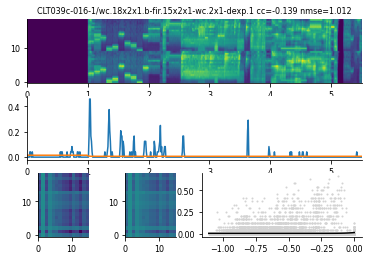

In [13]:
plot_binaural_model(model, X_val_h, Y_val=Y_val)

In [14]:
model.layers[0].coefficients[:,:,0]

array([[0.08149309, 0.07926235],
       [0.29202259, 0.05497681],
       [0.08952837, 0.01960737],
       [0.15771817, 0.1126147 ],
       [0.1178936 , 0.13089065],
       [0.07534454, 0.18796986],
       [0.11468807, 0.13420719],
       [0.13333824, 0.13854983],
       [0.10493172, 0.08114135],
       [0.09897345, 0.06305528],
       [0.11784113, 0.086597  ],
       [0.10988287, 0.0916924 ],
       [0.11904757, 0.00931432],
       [0.17560068, 0.13336368],
       [0.13512301, 0.16314632],
       [0.19514094, 0.12045474],
       [0.09156028, 0.1290338 ],
       [0.05981166, 0.23188318]])

## Fit with scipy backend

In [100]:
print('Fitting without NL ...')
model_sci = model0.copy()

model_sci.layers[-1].skip_nonlinearity()
model_sci = model_sci.fit(input=X_est, target=Y_est, backend='scipy',
          fitter_options={'cost_function': 'nmse', 'options': {'ftol': 0.0001, 'maxiter': 50}})

print('Now fitting with NL ...')
model_sci.layers[-1].unskip_nonlinearity()
model_sci = model.fit(input=X_est, target=Y_est, backend='scipy',
          fitter_options={'cost_function': 'nmse', 'options': {'ftol': 0.00001, 'maxiter': 100}})

Fitting without NL ...
Epoch 0
        Iteration 0, error is: 1.18191916...
Fit successful: True
Status: 0
Message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Now fitting with NL ...
Epoch 0
        Iteration 0, error is: 0.91764567...
        Iteration 5, error is: 0.91680986...
        Iteration 10, error is: 0.91513237...
        Iteration 15, error is: 0.91457561...
        Iteration 20, error is: 0.91210197...
        Iteration 25, error is: 0.91156625...
        Iteration 30, error is: 0.91078157...
        Iteration 35, error is: 0.91006482...
        Iteration 40, error is: 0.90903038...
        Iteration 45, error is: 0.90855759...
Fit successful: True
Status: 0
Message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH


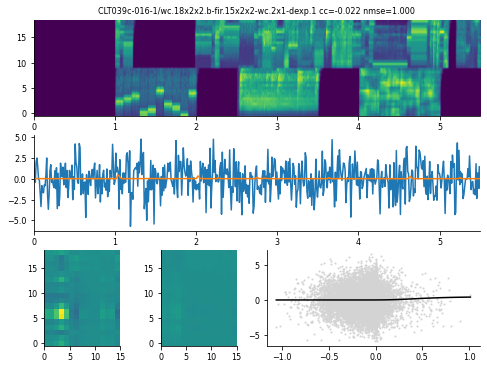

In [187]:
plot_binaural_model(model_sci, X_val, Y_val=Y_val)

Now reinitialize and fit again

In [80]:
model = Model.from_keywords(modelspec)
model = model.sample_from_priors();


In [81]:
fitter_options = {'cost_function': 'nmse', 'early_stopping_delay': 100, 'early_stopping_patience': 10,
              'early_stopping_tolerance': 1e-3, 'validation_split': 0.0,
              'learning_rate': 5e-3, 'epochs': 2000}

# Trying a TF fit:
model.layers[-1].skip_nonlinearity()
model = model.fit(input=np.expand_dims(X_est, axis=0),
          target=np.expand_dims(Y_est, axis=0), backend='tf',
          fitter_options=fitter_options,
          batch_size=None)

model.layers[-1].unskip_nonlinearity()
model = model.fit(input=np.expand_dims(X_est, axis=0),
          target=np.expand_dims(Y_est, axis=0), backend='tf',
          fitter_options=fitter_options,
          batch_size=None)

TF model built...
Model: "UnnamedModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 50000, 18, 2)]    0         
                                                                 
 wc (WeightChannelsMultiTF)  (None, 50000, 2, 2)       72        
                                                                 
 fir (FiniteImpulseResponseT  (None, 50000, 2)         60        
 F)                                                              
                                                                 
 wc0 (WeightChannelsTF)      (None, 50000, 1)          2         
                                                                 
 dexp (StaticNonlinearityTF)  (None, 50000, 1)         4         
                                                                 
Total params: 138
Trainable params: 135
Non-trainable params: 3
______________________________________

1/1 [==============================] - 0s 13ms/step - loss: 0.9977
Epoch 61/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.9960
Epoch 62/2000
1/1 [==============================] - 0s 14ms/step - loss: 0.9947
Epoch 63/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.9937
Epoch 64/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.9931
Epoch 65/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.9927
Epoch 66/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.9924
Epoch 67/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.9922
Epoch 68/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.9919
Epoch 69/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.9917
Epoch 70/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.9913
Epoch 71/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.9909
Epoch 72/2000
1/1 [=======================

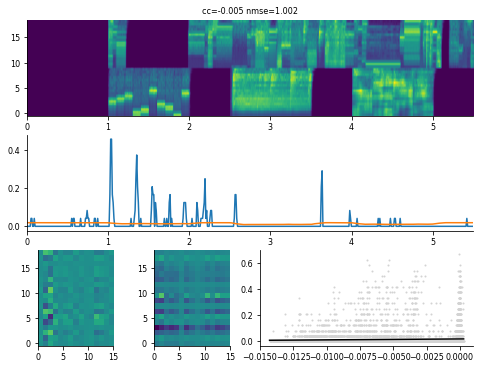

In [82]:
plot_binaural_model(model, X_val, Y_val=Y_val)

In [17]:
x1=model.predict(X_est)
x1.shape

(50000, 1)

In [18]:
x2=model.backend.predict(np.expand_dims(X_est, axis=0))[0,:,:]
x2.shape

(50000, 1)

In [13]:
np.corrcoef(x1[:,0],x2[:,0])

array([[1.        , 0.99982959],
       [0.99982959, 1.        ]])

In [19]:
np.corrcoef(x1[:,0],Y_est[:,0])

array([[ 1.        , -0.29751566],
       [-0.29751566,  1.        ]])

In [17]:
reps=15
cc=np.zeros(reps)
nmse=np.zeros(reps)

for i in range(reps):
    model = Model.from_keywords(modelspec)
    model = model.sample_from_priors();
    fitter_options = {'cost_function': 'nmse', 'early_stopping_delay': 100, 'early_stopping_patience': 10,
              'early_stopping_tolerance': 1e-3, 'validation_split': 0.0,
              'learning_rate': 5e-3, 'epochs': 2000}

    # Trying a TF fit:
    model.layers[-1].skip_nonlinearity()
    model = model.fit(input=np.expand_dims(X_est, axis=0),
              target=np.expand_dims(Y_est, axis=0), backend='tf',
              fitter_options=fitter_options,
              batch_size=None)

    model.layers[-1].unskip_nonlinearity()
    model = model.fit(input=np.expand_dims(X_est, axis=0),
              target=np.expand_dims(Y_est, axis=0), backend='tf',
              fitter_options=fitter_options,
              batch_size=None)
    
    # Predict the response to the stimulus spectrogram using the fitted model.
    prediction = model.predict(X_val)
    cc[i] = np.corrcoef(prediction[:, 0], Y_val[:, 0])[0, 1]
    nmse[i] = np.std(prediction-Y_val) / np.std(Y_val)
        

TF model built...
Model: "UnnamedModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 50000, 18, 2)]    0         
                                                                 
 wc (WeightChannelsMultiTF)  (None, 50000, 2, 2)       72        
                                                                 
 fir (FiniteImpulseResponseT  (None, 50000, 2)         60        
 F)                                                              
                                                                 
 wc0 (WeightChannelsTF)      (None, 50000, 1)          2         
                                                                 
 relu (StaticNonlinearityTF)  (None, 50000, 1)         3         
                                                                 
Total params: 137
Trainable params: 135
Non-trainable params: 2
______________________________________

1/1 [==============================] - 0s 13ms/step - loss: 0.8398
Epoch 61/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8396
Epoch 62/2000
1/1 [==============================] - 0s 14ms/step - loss: 0.8396
Epoch 63/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8395
Epoch 64/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8395
Epoch 65/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8395
Epoch 66/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8395
Epoch 67/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8395
Epoch 68/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8394
Epoch 69/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8394
Epoch 70/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8393
Epoch 71/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8393
Epoch 72/2000
1/1 [=======================

Epoch 69/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8100
Epoch 70/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8099
Epoch 71/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8098
Epoch 72/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8098
Epoch 73/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8097
Epoch 74/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8097
Epoch 75/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8096
Epoch 76/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8096
Epoch 77/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8096
Epoch 78/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8095
Epoch 79/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8095
Epoch 80/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8094
Epoch 81/2000
1/1 [=========

1/1 [==============================] - 0s 13ms/step - loss: 0.8178
Epoch 142/2000
1/1 [==============================] - 0s 21ms/step - loss: 0.8177
Epoch 143/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8176
Epoch 144/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8174
Epoch 145/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8173
Epoch 146/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8172
Epoch 147/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8170
Epoch 148/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8169
Epoch 149/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8167
Epoch 150/2000
1/1 [==============================] - 0s 15ms/step - loss: 0.8166
Epoch 151/2000
1/1 [==============================] - 0s 16ms/step - loss: 0.8164
Epoch 152/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8162
Epoch 153/2000
1/1 [===========

1/1 [==============================] - 0s 13ms/step - loss: 0.8618
Epoch 23/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8578
Epoch 24/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8538
Epoch 25/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8501
Epoch 26/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8469
Epoch 27/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8445
Epoch 28/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8428
Epoch 29/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8418
Epoch 30/2000
1/1 [==============================] - 0s 20ms/step - loss: 0.8415
Epoch 31/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8418
Epoch 32/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8423
Epoch 33/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8431
Epoch 34/2000
1/1 [=======================

1/1 [==============================] - 0s 15ms/step - loss: 0.8235
Epoch 124/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8229
Epoch 125/2000
1/1 [==============================] - 0s 15ms/step - loss: 0.8223
Epoch 126/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8217
Epoch 127/2000
1/1 [==============================] - 0s 15ms/step - loss: 0.8212
Epoch 128/2000
1/1 [==============================] - 0s 14ms/step - loss: 0.8208
Epoch 129/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8203
Epoch 130/2000
1/1 [==============================] - 0s 15ms/step - loss: 0.8199
Epoch 131/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8196
Epoch 132/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8193
Epoch 133/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8190
Epoch 134/2000
1/1 [==============================] - 0s 15ms/step - loss: 0.8188
Epoch 135/2000
1/1 [===========

Epoch 4/2000
1/1 [==============================] - 0s 13ms/step - loss: 1.0406
Epoch 5/2000
1/1 [==============================] - 0s 11ms/step - loss: 1.0005
Epoch 6/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.9617
Epoch 7/2000
1/1 [==============================] - 0s 11ms/step - loss: 0.9273
Epoch 8/2000
1/1 [==============================] - 0s 11ms/step - loss: 0.8993
Epoch 9/2000
1/1 [==============================] - 0s 11ms/step - loss: 0.8786
Epoch 10/2000
1/1 [==============================] - 0s 11ms/step - loss: 0.8650
Epoch 11/2000
1/1 [==============================] - 0s 11ms/step - loss: 0.8577
Epoch 12/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8555
Epoch 13/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8569
Epoch 14/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8602
Epoch 15/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8641
Epoch 16/2000
1/1 [===============

1/1 [==============================] - 0s 15ms/step - loss: 0.8338
Epoch 106/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8334
Epoch 107/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8330
Epoch 108/2000
1/1 [==============================] - 0s 15ms/step - loss: 0.8326
Epoch 109/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8321
Epoch 110/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8316
Epoch 111/2000
1/1 [==============================] - 0s 15ms/step - loss: 0.8311
Epoch 112/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8306
Epoch 113/2000
1/1 [==============================] - 0s 15ms/step - loss: 0.8300
Epoch 114/2000
1/1 [==============================] - 0s 14ms/step - loss: 0.8294
Epoch 115/2000
1/1 [==============================] - 0s 15ms/step - loss: 0.8288
Epoch 116/2000
1/1 [==============================] - 0s 16ms/step - loss: 0.8281
Epoch 117/2000
1/1 [===========

Epoch 00112: early stopping
TF model built...
Model: "UnnamedModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 50000, 18, 2)]    0         
                                                                 
 wc (WeightChannelsMultiTF)  (None, 50000, 2, 2)       72        
                                                                 
 fir (FiniteImpulseResponseT  (None, 50000, 2)         60        
 F)                                                              
                                                                 
 wc0 (WeightChannelsTF)      (None, 50000, 1)          2         
                                                                 
 relu (RectifiedLinearTF)    (None, 50000, 1)          3         
                                                                 
Total params: 137
Trainable params: 136
Non-trainable params: 1
__________

1/1 [==============================] - 0s 294ms/step - loss: 0.8773
Epoch 2/2000
1/1 [==============================] - 0s 10ms/step - loss: 0.8688
Epoch 3/2000
1/1 [==============================] - 0s 10ms/step - loss: 0.8614
Epoch 4/2000
1/1 [==============================] - 0s 10ms/step - loss: 0.8550
Epoch 5/2000
1/1 [==============================] - 0s 10ms/step - loss: 0.8496
Epoch 6/2000
1/1 [==============================] - 0s 11ms/step - loss: 0.8453
Epoch 7/2000
1/1 [==============================] - 0s 11ms/step - loss: 0.8421
Epoch 8/2000
1/1 [==============================] - 0s 11ms/step - loss: 0.8398
Epoch 9/2000
1/1 [==============================] - 0s 11ms/step - loss: 0.8384
Epoch 10/2000
1/1 [==============================] - 0s 11ms/step - loss: 0.8378
Epoch 11/2000
1/1 [==============================] - 0s 11ms/step - loss: 0.8377
Epoch 12/2000
1/1 [==============================] - 0s 18ms/step - loss: 0.8380
Epoch 13/2000
1/1 [==============================

1/1 [==============================] - 0s 14ms/step - loss: 0.8389
Epoch 76/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8388
Epoch 77/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8388
Epoch 78/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8387
Epoch 79/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8386
Epoch 80/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8385
Epoch 81/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8385
Epoch 82/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8384
Epoch 83/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8383
Epoch 84/2000
1/1 [==============================] - 0s 14ms/step - loss: 0.8382
Epoch 85/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8381
Epoch 86/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8380
Epoch 87/2000
1/1 [=======================

1/1 [==============================] - 0s 13ms/step - loss: 0.8092
Epoch 85/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8092
Epoch 86/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8092
Epoch 87/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8091
Epoch 88/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8091
Epoch 89/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8091
Epoch 90/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8090
Epoch 91/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8090
Epoch 92/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8090
Epoch 93/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8090
Epoch 94/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8089
Epoch 95/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8089
Epoch 96/2000
1/1 [=======================

1/1 [==============================] - 0s 13ms/step - loss: 0.8403
Epoch 58/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8401
Epoch 59/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8399
Epoch 60/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8398
Epoch 61/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8396
Epoch 62/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8396
Epoch 63/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8395
Epoch 64/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8395
Epoch 65/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8395
Epoch 66/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8395
Epoch 67/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8395
Epoch 68/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8394
Epoch 69/2000
1/1 [=======================

Epoch 66/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8102
Epoch 67/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8101
Epoch 68/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8100
Epoch 69/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8100
Epoch 70/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8099
Epoch 71/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8098
Epoch 72/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8098
Epoch 73/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8097
Epoch 74/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8097
Epoch 75/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8096
Epoch 76/2000
1/1 [==============================] - 0s 14ms/step - loss: 0.8096
Epoch 77/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8096
Epoch 78/2000
1/1 [=========

1/1 [==============================] - 0s 14ms/step - loss: 0.8181
Epoch 139/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8180
Epoch 140/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8179
Epoch 141/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8178
Epoch 142/2000
1/1 [==============================] - 0s 15ms/step - loss: 0.8177
Epoch 143/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8176
Epoch 144/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8174
Epoch 145/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8173
Epoch 146/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8172
Epoch 147/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8170
Epoch 148/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8169
Epoch 149/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8167
Epoch 150/2000
1/1 [===========

1/1 [==============================] - 0s 13ms/step - loss: 0.8704
Epoch 20/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8685
Epoch 21/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8655
Epoch 22/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8618
Epoch 23/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8578
Epoch 24/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8538
Epoch 25/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8501
Epoch 26/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8469
Epoch 27/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8445
Epoch 28/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8428
Epoch 29/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8418
Epoch 30/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8415
Epoch 31/2000
1/1 [=======================

1/1 [==============================] - 0s 13ms/step - loss: 0.8255
Epoch 121/2000
1/1 [==============================] - 0s 15ms/step - loss: 0.8248
Epoch 122/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8242
Epoch 123/2000
1/1 [==============================] - 0s 15ms/step - loss: 0.8235
Epoch 124/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8229
Epoch 125/2000
1/1 [==============================] - 0s 15ms/step - loss: 0.8223
Epoch 126/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8217
Epoch 127/2000
1/1 [==============================] - 0s 15ms/step - loss: 0.8212
Epoch 128/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8208
Epoch 129/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8203
Epoch 130/2000
1/1 [==============================] - 0s 15ms/step - loss: 0.8199
Epoch 131/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8196
Epoch 132/2000
1/1 [===========

Epoch 1/2000
1/1 [==============================] - 0s 322ms/step - loss: 1.1471
Epoch 2/2000
1/1 [==============================] - 0s 11ms/step - loss: 1.1152
Epoch 3/2000
1/1 [==============================] - 0s 11ms/step - loss: 1.0794
Epoch 4/2000
1/1 [==============================] - 0s 10ms/step - loss: 1.0406
Epoch 5/2000
1/1 [==============================] - 0s 11ms/step - loss: 1.0005
Epoch 6/2000
1/1 [==============================] - 0s 11ms/step - loss: 0.9617
Epoch 7/2000
1/1 [==============================] - 0s 11ms/step - loss: 0.9273
Epoch 8/2000
1/1 [==============================] - 0s 11ms/step - loss: 0.8993
Epoch 9/2000
1/1 [==============================] - 0s 11ms/step - loss: 0.8786
Epoch 10/2000
1/1 [==============================] - 0s 11ms/step - loss: 0.8650
Epoch 11/2000
1/1 [==============================] - 0s 11ms/step - loss: 0.8577
Epoch 12/2000
1/1 [==============================] - 0s 11ms/step - loss: 0.8555
Epoch 13/2000
1/1 [=================

1/1 [==============================] - 0s 11ms/step - loss: 0.8378
Epoch 11/2000
1/1 [==============================] - 0s 11ms/step - loss: 0.8377
Epoch 12/2000
1/1 [==============================] - 0s 11ms/step - loss: 0.8380
Epoch 13/2000
1/1 [==============================] - 0s 11ms/step - loss: 0.8385
Epoch 14/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8390
Epoch 15/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8393
Epoch 16/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8393
Epoch 17/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8390
Epoch 18/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8383
Epoch 19/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8371
Epoch 20/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8355
Epoch 21/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8336
Epoch 22/2000
1/1 [=======================

1/1 [==============================] - 0s 12ms/step - loss: 0.8086
Epoch 112/2000
1/1 [==============================] - 0s 15ms/step - loss: 0.8086
Epoch 00112: early stopping
TF model built...
Model: "UnnamedModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 50000, 18, 2)]    0         
                                                                 
 wc (WeightChannelsMultiTF)  (None, 50000, 2, 2)       72        
                                                                 
 fir (FiniteImpulseResponseT  (None, 50000, 2)         60        
 F)                                                              
                                                                 
 wc0 (WeightChannelsTF)      (None, 50000, 1)          2         
                                                                 
 relu (RectifiedLinearTF)    (None, 50000, 1)          3 

1/1 [==============================] - 0s 12ms/step - loss: 0.8382
Epoch 85/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8381
Epoch 86/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8380
Epoch 87/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8379
Epoch 88/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8377
Epoch 89/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8376
Epoch 90/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8374
Epoch 91/2000
1/1 [==============================] - 0s 14ms/step - loss: 0.8373
Epoch 92/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8371
Epoch 93/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8370
Epoch 94/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8368
Epoch 95/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8366
Epoch 96/2000
1/1 [=======================

1/1 [==============================] - 0s 294ms/step - loss: 0.8773
Epoch 2/2000
1/1 [==============================] - 0s 9ms/step - loss: 0.8688
Epoch 3/2000
1/1 [==============================] - 0s 10ms/step - loss: 0.8614
Epoch 4/2000
1/1 [==============================] - 0s 10ms/step - loss: 0.8550
Epoch 5/2000
1/1 [==============================] - 0s 10ms/step - loss: 0.8496
Epoch 6/2000
1/1 [==============================] - 0s 11ms/step - loss: 0.8453
Epoch 7/2000
1/1 [==============================] - 0s 11ms/step - loss: 0.8421
Epoch 8/2000
1/1 [==============================] - 0s 10ms/step - loss: 0.8398
Epoch 9/2000
1/1 [==============================] - 0s 11ms/step - loss: 0.8384
Epoch 10/2000
1/1 [==============================] - 0s 11ms/step - loss: 0.8378
Epoch 11/2000
1/1 [==============================] - 0s 11ms/step - loss: 0.8377
Epoch 12/2000
1/1 [==============================] - 0s 11ms/step - loss: 0.8380
Epoch 13/2000
1/1 [==============================]

1/1 [==============================] - 0s 12ms/step - loss: 0.8389
Epoch 76/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8388
Epoch 77/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8388
Epoch 78/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8387
Epoch 79/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8386
Epoch 80/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8385
Epoch 81/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8385
Epoch 82/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8384
Epoch 83/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8383
Epoch 84/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8382
Epoch 85/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8381
Epoch 86/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8380
Epoch 87/2000
1/1 [=======================

1/1 [==============================] - 0s 13ms/step - loss: 0.8092
Epoch 85/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8092
Epoch 86/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8092
Epoch 87/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8091
Epoch 88/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8091
Epoch 89/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8091
Epoch 90/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8090
Epoch 91/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8090
Epoch 92/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8090
Epoch 93/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8090
Epoch 94/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8089
Epoch 95/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8089
Epoch 96/2000
1/1 [=======================

1/1 [==============================] - 0s 13ms/step - loss: 0.8403
Epoch 58/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8401
Epoch 59/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8399
Epoch 60/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8398
Epoch 61/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8396
Epoch 62/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8396
Epoch 63/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8395
Epoch 64/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8395
Epoch 65/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8395
Epoch 66/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8395
Epoch 67/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8395
Epoch 68/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8394
Epoch 69/2000
1/1 [=======================

Epoch 66/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8102
Epoch 67/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8101
Epoch 68/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8100
Epoch 69/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8100
Epoch 70/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8099
Epoch 71/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8098
Epoch 72/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8098
Epoch 73/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8097
Epoch 74/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8097
Epoch 75/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8096
Epoch 76/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8096
Epoch 77/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8096
Epoch 78/2000
1/1 [=========

1/1 [==============================] - 0s 12ms/step - loss: 0.8181
Epoch 139/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8180
Epoch 140/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8179
Epoch 141/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8178
Epoch 142/2000
1/1 [==============================] - 0s 14ms/step - loss: 0.8177
Epoch 143/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8176
Epoch 144/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8174
Epoch 145/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8173
Epoch 146/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8172
Epoch 147/2000
1/1 [==============================] - 0s 15ms/step - loss: 0.8170
Epoch 148/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8169
Epoch 149/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8167
Epoch 150/2000
1/1 [===========

1/1 [==============================] - 0s 12ms/step - loss: 0.8704
Epoch 20/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8685
Epoch 21/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8655
Epoch 22/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8618
Epoch 23/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8578
Epoch 24/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8538
Epoch 25/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8501
Epoch 26/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8469
Epoch 27/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8445
Epoch 28/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8428
Epoch 29/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8418
Epoch 30/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8415
Epoch 31/2000
1/1 [=======================

1/1 [==============================] - 0s 13ms/step - loss: 0.8255
Epoch 121/2000
1/1 [==============================] - 0s 15ms/step - loss: 0.8248
Epoch 122/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8242
Epoch 123/2000
1/1 [==============================] - 0s 15ms/step - loss: 0.8235
Epoch 124/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8229
Epoch 125/2000
1/1 [==============================] - 0s 14ms/step - loss: 0.8223
Epoch 126/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8217
Epoch 127/2000
1/1 [==============================] - 0s 15ms/step - loss: 0.8212
Epoch 128/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8208
Epoch 129/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8203
Epoch 130/2000
1/1 [==============================] - 0s 15ms/step - loss: 0.8199
Epoch 131/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8196
Epoch 132/2000
1/1 [===========

In [18]:
cc,nmse

(array([0.50333618, 0.50333621, 0.50333622, 0.5033362 , 0.5033362 ,
        0.50333617, 0.50333622, 0.50333621, 0.50333621, 0.50333622,
        0.50333617, 0.50333619, 0.50333618, 0.50333621, 0.5033362 ]),
 array([0.86485837, 0.86485836, 0.86485835, 0.86485836, 0.86485836,
        0.86485838, 0.86485835, 0.86485836, 0.86485836, 0.86485835,
        0.86485837, 0.86485837, 0.86485837, 0.86485836, 0.86485836]))

In [19]:
!hostname

manatee


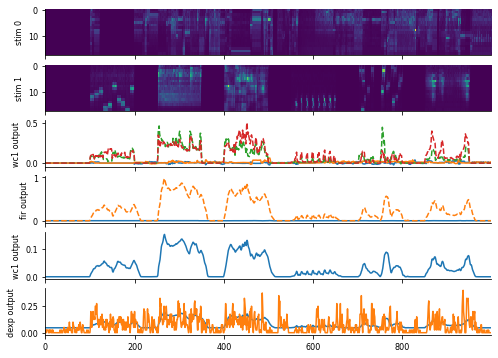

In [21]:
plot_binaural_layers(model, X_val, Y_val=Y_val)

Fit with scipy backend

In [ ]:
print('Fitting without NL ...')
model.layers[-1].skip_nonlinearity()
model = model.fit(input=X_est, target=Y_est, backend='scipy',
          fitter_options={'cost_function': 'nmse', 'options': {'ftol': 0.00000001, 'maxiter': 50}})

print('Now fitting with NL ...')
model.layers[-1].unskip_nonlinearity()
model = model.fit(input=X_est, target=Y_est, backend='scipy',
          fitter_options={'cost_function': 'nmse', 'options': {'ftol': 0.000000001, 'maxiter': 100}})

Fitting without NL ...
Epoch 0
        Iteration 0, error is: 1.00072953...


Test that model does what it's supposed to do with each coefficient

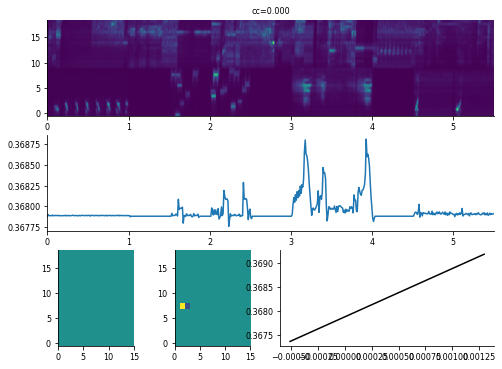

In [5]:
model = Model.from_keywords(modelspec)

wc = model.layers[0]['coefficients'].values
wc[:]=0
wc[7,1,1]=1
model.layers[0]['coefficients'] = wc

fir = model.layers[1]['coefficients'].values
fir[:]=0
fir[1,1,1]=0.5
fir[2,1,1]=-0.25
model.layers[1]['coefficients'] = fir

wc2 = model.layers[2]['coefficients'].values
wc2[0] = 1
model.layers[2]['coefficients'] = wc2

#print(model.layers[3]['shift'].values, model.layers[3]['offset'].values, model.layers[3]['gain'].values)

plot_binaural_model(model, X_val, Y_val=None)
#plot_binaural_layers(model, X_val, Y_val=None)